<h1>Multi-Touch Attribution with Shapley Values</h1>

The purpose of this notebook is to demonstrate how Shapley values can be used to measure channel contribution in a multi-touch attribution setting. This notebook will provide code for implementing a standard version of Shapley values to multi-touch problem. The results, here, are only for demonstration and are based on a sample data base which may not represent real-world situations.

## 1. Introduction to Shapley values <a name="se:intro"></a>

Shapley values application in multi-touch attribution settings are inspired by the **cooperative game theory** where a coalitition of players cooperate to achieve a certain total utility. However, the contribution of each player might be different to the total goal. Shapley values are one possible answer to a unique distribution of utility among all players generated by the coalition of all players.

In multi-touch attribution settings, different touchpoints of a customer in its journey towards conversion are thought of as a coalition. For example, the following particular customer journey

*journey1*: <span style="color:blue">NATURAL SEARCH --> PAID SEARCH --> SOCIAL MEDIA ==> CONVERSION </span> <br>

will construct of a coalition of $\{$<span style="color:blue">NATURAL SEARCH, PAID SEARCH, SOCIAL MEDIA</span>$\}$ channels (players). This particular coalition may show up in other customer journeys as well. The total utility generated by the coalition of all players will be equal to the total number of conversions (or total conversion rate). Shapley values will measure the worth of each coalition as well as the contribution of each player to the total utility generated. A channel's Shapley value (contribution) may be considered as its attribution.

![Shapley values](shap.png)

A symetric version of Shapley values are typically formulated according to the following

$$\phi_i(\nu, N) = \sum_{S\subseteq N\setminus \{i\}} \frac{|S|!(n-|S|-1)!}{n!}\Big(\nu(S\cup\{i\})-\nu(S)\Big)$$

where $N$ is the set of all channels and $\nu$ denots a mapping function between a coalition and a real number corresponding to the worth (utility) of a coalition. The formulation can be interpreted as the sum of marginal contributions of each channel, i.e., $\nu(S\cup\{i\})-\nu(S)$ to coalition $S$ averaged over all possible different permutation in which coalition $S$ can be formed.

## 2. Read-in sample data base <a name="se:data"></a>

A sample data base is provided which consists of `601776` customer identifier keys and the customer journeys to conversion or loss. Customer journeys are created from raw customer interactions (clicks, impressions, etc.) where individual interactions are grouped by an customer identifer key (e.g., cookie id), sorted by a timestamp (e.g., time of interaction) and joined together. For more details, refer to [Data Transformation](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/Data%20Transformations/index.html) section of [Customer Journey Analytics](#https://blend360-measurement-library.readthedocs-hosted.com/en/latest/content/Customer%20Journey%20Analytics/index.html). The sample data set is investigated to see no duplicate values are present in customer IDs. **NOTE** that this data set assumes only a homogeneous set of consumers.

In [1]:
import os
import inspect
import pandas as pd
curr_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(curr_dir)
path_df = pd.read_csv(os.path.join(parent_dir, 
                                   "../Data Transformations/raw data/customer_journey_sample_data.csv"), 
                      index_col = 0)
print(f'The data frame includes {list(path_df.columns)} columns \
and {len(path_df.PGM_FREQ_MEMBER_KEY.unique())} distinct rows')
path_df.head(5)

The data frame includes ['PGM_FREQ_MEMBER_KEY', 'CAM_DEV', 'CONVERSION'] columns and 601776 distinct rows


,PGM_FREQ_MEMBER_KEY,CAM_DEV,CONVERSION
0,-9223328556171841832,"['NATURAL SEARCH|DESKTOP', 'REFERRAL ENGINE|DE...",1
1,-9223242021294710602,"['NATURAL SEARCH|DESKTOP', 'PAID SEARCH|DESKTOP']",1
2,-9223227354203035958,['DIRECT|DESKTOP'],0
3,-9223216806413203389,"['DIRECT|DESKTOP', 'NATURAL SEARCH|DESKTOP']",1
4,-9223197902225736847,"['NATURAL SEARCH|DESKTOP', 'DIRECT|DESKTOP', '...",1


In [2]:
import re
unique_channel_lst = set(channel for path in path_df.CAM_DEV.str.replace("[\[\'\]]", "", regex = True)\
                                                            .str.split(", ") for channel in path)
print(unique_channel_lst)

{'NATURAL SEARCH|MOBILE', 'PAID SEARCH|DESKTOP', 'DIRECT|DESKTOP', 'ECONFO AND PRE-ARRIVAL EMAIL|DESKTOP', 'DIRECT|MOBILE', 'SOCIAL MEDIA|DESKTOP', 'DISPLAY|DESKTOP', 'DISPLAY|MOBILE', 'EMAIL|DESKTOP', 'B2B|DESKTOP', 'UNPAID REFERRER|DESKTOP', 'AFFILIATE|DESKTOP', 'RESLINK|DESKTOP', 'REFERRAL ENGINE|DESKTOP', 'OTHER|MOBILE', 'OTHER|DESKTOP', 'NATURAL SEARCH|DESKTOP', 'RESLINK|MOBILE', 'SOCIAL MEDIA|MOBILE', 'UNPAID REFERRER|MOBILE', 'REFERRAL ENGINE|MOBILE', 'ECONFO AND PRE-ARRIVAL EMAIL|MOBILE', 'PAID SEARCH|MOBILE', 'EMAIL|MOBILE', 'TEST|DESKTOP', 'AFFILIATE|MOBILE'}


**Dimension Reduction**: To simply the analysis and ease the computation effort, some of the states in the `unique_state_lst` are grouped together into `OTHER`. <span style="color:blue">**NOTE** that by leaving the `other_state_lst` list empty, the following Markov chain analyses will consider all the original states.</span>

In [3]:
other_channel_lst = []
## uncomment below to reduce the number of states
other_channel_lst = ['ECONFO AND PRE-ARRIVAL EMAIL|MOBILE', 
                    'ECONFO AND PRE-ARRIVAL EMAIL|DESKTOP', 
                    'OTHER|MOBILE', 
                    'OTHER|DESKTOP',
                    'UNPAID REFERRER|MOBILE',
                    'UNPAID REFERRER|DESKTOP',
                    'TEST|DESKTOP',
                    'B2B|DESKTOP',
                    'RESLINK|MOBILE', 
                    'RESLINK|DESKTOP']
unique_channel_lst = set(channel if channel not in other_channel_lst else 'OTHER' for channel in unique_channel_lst)
print(unique_channel_lst)

{'OTHER', 'DISPLAY|MOBILE', 'REFERRAL ENGINE|MOBILE', 'EMAIL|DESKTOP', 'REFERRAL ENGINE|DESKTOP', 'PAID SEARCH|MOBILE', 'EMAIL|MOBILE', 'NATURAL SEARCH|MOBILE', 'PAID SEARCH|DESKTOP', 'SOCIAL MEDIA|MOBILE', 'DIRECT|DESKTOP', 'NATURAL SEARCH|DESKTOP', 'AFFILIATE|MOBILE', 'AFFILIATE|DESKTOP', 'DIRECT|MOBILE', 'SOCIAL MEDIA|DESKTOP', 'DISPLAY|DESKTOP'}


The function below transfroms the path into a `frozenset` to form coalitions. <span style="color:blue;">**NOTE** that By this transformation, the following two journeys will have the same coalitin</span>. 

*journey1*: <span style="color:blue">NATURAL SEARCH --> PAID SEARCH --> SOCIAL MEDIA ==> CONVERSION </span> <br>
*journey2*: <span style="color:blue">PAID SEARCH --> NATURAL SEARCH --> PAID SEARCH --> SOCIAL MEDIA ==> CONVERSION </span> <br>

This transformation, therefore, is agnostic with respect to order of channels and multiple visits to the same channle in customer journeys. For the purposes of a standard Shapley values approach to attribution, this assumption is neccessary. However, there are modifications to the Shapley values method which can differentiate between the order of channels in a customer journey. For more details, refer to [**WORK IN PROGRESS**](#).

In [4]:
def transform_to_coalition(path, other_channel_lst):
    import ast
    path = ast.literal_eval(path)
    path = [channel if channel not in other_channel_lst else 'OTHER' for channel in path]
    if type(path) != list:
        raise TypeError('Error: Customer journey cannot be translated to a list')
    return frozenset(path)

In [5]:
path_df['COALITION'] = path_df.apply(lambda x: transform_to_coalition(x['CAM_DEV'], other_channel_lst), axis = 1)
path_df.head(5)

,PGM_FREQ_MEMBER_KEY,CAM_DEV,CONVERSION,COALITION
0,-9223328556171841832,"['NATURAL SEARCH|DESKTOP', 'REFERRAL ENGINE|DE...",1,"(NATURAL SEARCH|DESKTOP, REFERRAL ENGINE|DESKT..."
1,-9223242021294710602,"['NATURAL SEARCH|DESKTOP', 'PAID SEARCH|DESKTOP']",1,"(NATURAL SEARCH|DESKTOP, PAID SEARCH|DESKTOP)"
2,-9223227354203035958,['DIRECT|DESKTOP'],0,(DIRECT|DESKTOP)
3,-9223216806413203389,"['DIRECT|DESKTOP', 'NATURAL SEARCH|DESKTOP']",1,"(NATURAL SEARCH|DESKTOP, DIRECT|DESKTOP)"
4,-9223197902225736847,"['NATURAL SEARCH|DESKTOP', 'DIRECT|DESKTOP', '...",1,"(NATURAL SEARCH|DESKTOP, DIRECT|DESKTOP, EMAIL..."


## 3. Measure of utility <a name="se:utility"></a>

Before evaluting Shapley values, a measure of utility for each channel (or coalition of channels) should be defined. To evaluate channel attribution, number of conversions or conversion rates (or a function of them) are typically used. The first step to that end would be to manipulate the `path_df` data frame to calculate the number of conversion and losses per each unique coaltion. Then, the resulting data frame is transformed to also include conversion rates which would be conversion numbers divided by total number of journeys.

In [6]:
## count individual journeys that resulted in LOSS (0) or CONVERSION (1)
coalition_df = path_df.groupby(['COALITION', 'CONVERSION'])['PGM_FREQ_MEMBER_KEY']\
                      .count()\
                      .reset_index()\
                      .rename(columns = {'PGM_FREQ_MEMBER_KEY': 'count'})
## pivot to wide
coalition_df = coalition_df.pivot(index = 'COALITION', 
                                  columns = 'CONVERSION', 
                                  values = 'count')\
                           .reset_index()\
                           .fillna(0)\
                           .rename(columns = {0: 'LOSS', 
                                              1: 'CONVERSION'})
## evaluate conversion rate
coalition_df['conversion_rate'] = coalition_df.CONVERSION / (sum(coalition_df.CONVERSION) + sum(coalition_df.LOSS))

## export to a dictionary for later use
coalition_conversion_dict = coalition_df.set_index('COALITION').to_dict('index')
coalition_df.head(5)

CONVERSION,COALITION,LOSS,CONVERSION,conversion_rate
0,"(NATURAL SEARCH|DESKTOP, REFERRAL ENGINE|DESKT...",5.0,4.0,0.000007
1,(EMAIL|DESKTOP),8298.0,1602.0,0.002662
2,(DIRECT|MOBILE),27126.0,7653.0,0.012717
3,"(NATURAL SEARCH|DESKTOP, PAID SEARCH|DESKTOP)",11627.0,9255.0,0.015379
4,"(OTHER, EMAIL|DESKTOP, PAID SEARCH|DESKTOP, NA...",65.0,41.0,0.000068


### 3.1. Utility function <a name="sse:util-func"></a>

As introduced in [Section 1](#se:intro), marginal contribution of a channel to a coalition, $S$ is measured by a utility function, e.g., $\nu(S)$. In multi-touch attribution settings, number of conversions or conversion rates are typically used as utility functions. In this implementation, number of conversions is used to measure the utility of a coalition. 

To reduce computation time, all possible combinations of channels in the `unique_channel_lst` are created to form every potential coalition and evaluate them before calculating Shapley values. This is achieved by `power_set` and `utility_func` functions below. `power_set` generates the power set (set of all subset) of a given set except for the empty set. `utility_func` goes through the power set of a given set and looks up the conversion number (in `coalition_conversion_dict`) for each subset returning the sum. 

In [7]:
def power_set(set_lst):
    import numpy as np
    if len(set_lst) != len(np.unique(np.array(set_lst))):
        raise ValueError('Error: Multiple occurances of the same item! Passed argument is not a set.')
    from itertools import combinations
    PS = [list(j) for i in range(len(set_lst)) for j in combinations(set_lst, i + 1)]
    return PS

In [8]:
def utility_func(coalition):
    temp_pow_set = power_set(list(coalition))
    return sum([coalition_conversion_dict[frozenset(subset)]['CONVERSION'] 
                    if frozenset(subset) in coalition_conversion_dict.keys() 
                    else 0 
                for subset in temp_pow_set])

**Evaluating all potential coalitions' utility**: below, the power set of all channels is calculated and iterated over to evaluate utility for each coalition member of the power set. `tqdm` library is used to show a progress bar for the loop as this is one of the most time consuming steps in calculating Shapley values. 

In [9]:
super_set = power_set(list(unique_channel_lst))

In [10]:
from tqdm import tqdm
coalition_utilities = {}
for coalition in tqdm(super_set):
    coalition_utilities[frozenset(coalition)] = utility_func(set(coalition))

100%|█████████████████████████████████████████████████████████████████████████| 131071/131071 [02:34<00:00, 849.81it/s]


## 4. Shapley values <a name="se:shapley"></a>

Here, the Shapley values introduced in [Section 1](#se:intro) is calculated for each channel. For a channel, Shapley values is evaluated by iterating over coalitions that do not include that channel. Adding the channel to that coalition will allow for measuring the marginal contribution of that channel to a coalition. The overall Shapley value for a channel is the sum of weighted marginal contribution over all coalitions in the power set.

Below, for each channel in the `unique_channel_lst`, every coalition in the super set (power set of `unique_channel_lst`) is iterated over to measure the marginal contribution if that channel was added to the coalition. Since, this set up cannot accommodate single channel coalitions, the coalition utility for one member coalitions are added at the end.

In [11]:
from math import factorial
shapley_values = {}
for channel in tqdm(unique_channel_lst):
    shapley_values[channel] = 0
    for S in coalition_utilities.keys():
        n = len(unique_channel_lst)
        
        if channel not in S:
           
            coalition = S
            cardinal_S = len(coalition)
            coalition_with_S = tuple(sorted([channel] + list(coalition)))
            S_plus_channel = frozenset([channel] + list(S))
           
            marginal_contribution = coalition_utilities[S_plus_channel] - coalition_utilities[S]
            
            wt = (factorial(cardinal_S) * factorial(n - cardinal_S - 1) / factorial(n))
            shapley_values[channel] += wt * marginal_contribution
            
    shapley_values[channel] += coalition_utilities[frozenset([channel])] / n

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  3.21it/s]


In [12]:
shapley_values_df = pd.DataFrame.from_dict(shapley_values, orient = 'index', columns = ['attribution'])
shapley_values_df.reset_index(inplace = True)
shapley_values_df.rename(columns = {'index': 'channel'}, inplace = True)
shapley_values_df.sort_values(by = 'attribution', ascending = False, inplace = True)
shapley_values_df.reset_index(drop = True, inplace = True)
shapley_values_df

,channel,attribution
0,DIRECT|DESKTOP,75435.882287
1,NATURAL SEARCH|DESKTOP,60098.388240
2,OTHER,19255.189033
3,DIRECT|MOBILE,15232.921176
4,PAID SEARCH|DESKTOP,13437.128716
5,EMAIL|DESKTOP,11738.253247
6,NATURAL SEARCH|MOBILE,9647.744986
7,REFERRAL ENGINE|DESKTOP,4871.188600
8,AFFILIATE|DESKTOP,4731.230988
9,EMAIL|MOBILE,3255.225938


### 4.1. QA check <a name="sse:shapley-qa"></a>

One way to ensure that channel attributions are correctly calculated is to compare sum of channel attribution and total conversion. Recall from [Section 1](#se:intro) that Shapley values essentially are a unique way to distribute total utility (= total number of conversions) among different channels. Therefore, sum of channel attribution should equal to total conversion. <span style="color:orange;">**NOTE**</span> that this is true only because the utility function is selected to be the number of conversion in this implementation; see [Section 2](#se:utility). For example, if conversion rate was selected as the utility function, then some of channel attribution would have to equal total conversion rate.

The following cell compares this sum and raises an error in case of inequality.

In [13]:
if round(shapley_values_df.attribution.sum()) != round(coalition_df.CONVERSION.sum()):
    raise ValueError('Error: Shapley values do not add up to total utility.')

print("Total utility: ", coalition_df.CONVERSION.sum())
print("Sum of Shapley values: ", shapley_values_df.attribution.sum())

Total utility:  224609.0
Sum of Shapley values:  224608.99999999948


### 4.2. Visualization <a name="sse:shapley-viz"></a>

To visualize the results, a barplot is generated based on Shapley values. <span style="color:blue;">**NOTE**</span> that the attribution are sorted in a descending order. Each bar is annotated by raw attribution and its relative percentage with respect to total utility.

In [14]:
shapley_values_df['per'] = shapley_values_df.attribution / shapley_values_df.attribution.sum()

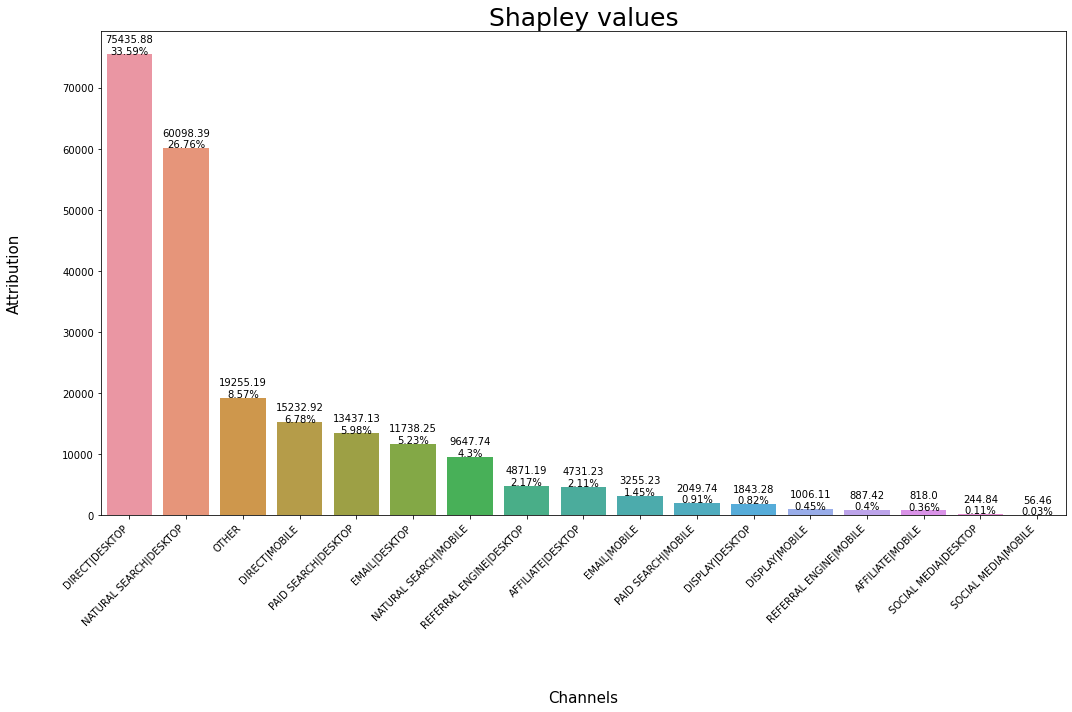

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
fig, ax = plt.subplots(figsize = (15, 10))
g = sns.barplot(x = 'channel', 
                y = 'attribution', 
                data = shapley_values_df)
for index, row in shapley_values_df.iterrows():
    g.text(row.name, 
           row.attribution + 100, 
           str(round(row.attribution, 2)) + "\n" + str(round(row.per * 100, 2)) + "%", 
           color = 'black', 
           ha = "center")
g.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')
g.set_title('Shapley values', fontsize = 25)
plt.xlabel("Channels", labelpad = 60, fontsize = 15)
plt.ylabel("Attribution", labelpad = 40, fontsize = 15)
plt.tight_layout()
plt.show()
plt.show()